<a href="https://colab.research.google.com/github/asvillela/u/blob/main/u!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Still to do:  
publish to github  
post it on alura's discord

<img align="right" width="300" height="300" src="http://drive.google.com/uc?export=view&id=1HBP2hJQw5vYCouNEqvZGHZggaf-HaMCn">

# **Looking for a job in a startup?**<br>This is the tool for **u!**

Do you think Companies read all CVs they receive? No way! They use algorithms to filter the best potential CVs based on keywords that match what they are looking for.  

**Why not do the same, but the other way around?**  
Instead of Companies filtering Candidates' CVs, this tool enables you to ***filter Companies*** based on what's important to **u!**  

**How does it work?**  
**u!** has a database of startups companies and a classification of the most relevant keywords related to each company. Then, you will upload your CV, and the tool will identify what is important to **u!**  
Finally, the tool will identify the startup companies with the best fit with your CV, and draft cover letters designed to each of those companies, personalized with your skills and experiences!  

Give it a shot and good luck with your job hunting!

# **Procurando emprego em uma startup?**<br> Essa é a ferramenta para você!

Você acha mesmo que as empresas leem todos os CVs que recebem? Claro que não! Elas usam algorítmos para filtrar os melhores CVs baseado em palavras chave que se encaixam no que estão buscando.

**Porque não fazer o mesmo, só que ao contrário?**
Ao invés de Empresas filtrando CVs dos Candidatos, essa ferramenta te permite **filtrar Empresas** baseado no que é importante pra **você**!

**Como funciona?**  
A ferramenta **u!** tem uma base de dados de startups e uma classificação das palavras chave mais relevantes para cada uma dessas empresas. Além disso, você vai fazer o upload do seu currículo, e a ferramenta vai identificar o que é importante pra *você*, baseado nas suas experiências e habilidades.  
Finalmente, a ferramenta identificará quais são as startups que se encaixam melhor com o **seu** perfil, e criará rascunhos de Cover Letters especificamente para cada uma dessas empresas, personalizadas com suas habilidades e experiências!  

Boa sorte com sua busca de emprego!

<img align="right" width="100" height="100" src="http://drive.google.com/uc?export=view&id=1CJ28YBPgvgE1HKSLNULiRU1AOrC3-4Zh">

# Instal and import packages and libraries
Instalar e importar bibliotecas e pacotes

In [1]:
!pip install -U -q google-generativeai
!pip install kaggle
!pip install spacy
!pip install wordcloud
!pip install python-docx
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import google.generativeai as genai
import os
import pandas as pd
import spacy
import docx
import json
import matplotlib.pyplot as plt
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from collections import Counter
from google.colab import userdata

<img align="right" width="202" height="78" src="http://drive.google.com/uc?export=view&id=1OBzNnh5iDQDDcH4zzVIXO7QQbH90Ta7w">

https://drive.google.com/file/d/1OBzNnh5iDQDDcH4zzVIXO7QQbH90Ta7w/view?usp=sharing

# Get Startups database from Kaggle
Importar database de startups do Kaggle


Note: if you re-run this cell block, folder will already be created and files will already be uploaded. You will then be asked if you want to replace the files. By clicking to the right of each question, you can input your response.  
Example:  
replace startups/Founders.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n  
replace startups/README(1).md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n  
replace startups/Startups.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n  

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d joebeachcapital/startups
!mkdir startups
!unzip startups.zip -d startups
file_path = os.path.join(os.getcwd(), 'startups', 'Startups.csv')
startups_df = pd.read_csv(file_path)

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/startups
License(s): CC-BY-SA-4.0
startups.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘startups’: File exists
Archive:  startups.zip
replace startups/Founders.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace startups/README(1).md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace startups/Startups.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


<img align="right" width="100" height="100" src="http://drive.google.com/uc?export=view&id=1cv8xd1bsH9ugWxp6flKCv0S0alZ-dQiz">

# Identify keywords for each startup
Identificar palavras chave de cada startup.


In [4]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Special cases for compound terms that I don't want broken down or changed
special_cases = ['e-commerce', 'machine learning', 'real time', 'artificial intelligence', 'data']

# Generic words to be excluded
exclusions = ['service', 'platform', 'online', 'user', 'allow', 'enable', 'offer', 'company',
              'business', 'share', 'tool', 'email', 'startup', 'create', 'build', 'provide',
              'help']

# Terms to be normalized. For example: I don't want 'site' and 'website' to be 2 different keywords.
normalization_dict = {
    'site': 'website',
    'app': 'application',
    'senior finance': 'finance',
    'financial': 'finance',
    'data': 'data'
}

for term in special_cases:
    nlp.tokenizer.add_special_case(term, [{spacy.symbols.ORTH: term}])

# Set up a PhraseMatcher for compound terms if necessary
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')
patterns = [nlp.make_doc(text) for text in special_cases]
matcher.add("COMPOUND_TERMS", patterns)

# Function to extract keywords using part-of-speech tagging
def extract_keywords(text):
    doc = nlp(text)
    matches = matcher(doc)

    # Create Span objects for the matched phrases so they are not split in further processing
    spans = [Span(doc, start, end, label="COMPOUND") for _, start, end in matches]
    with doc.retokenize() as retokenizer:
        for span in spans:
            retokenizer.merge(span)

    # Extract keywords using lemmatization and POS filtering
    keywords = [normalization_dict.get(token.lemma_, token.lemma_) for token in doc
                if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'VERB']
                and not token.is_stop
                and token.lemma_ not in exclusions]

    # Create a set of phrases to avoid duplicates
    phrase_set = set([span.text for span in spans])

    # Append phrases ensuring no duplication
    for phrase in phrase_set:
        if phrase not in keywords:
            keywords.append(phrase)

    return keywords

### Create counter de keywords
Criar um contador de palavras chave

In [5]:
def count_common_items(df, column_name):
  all_items = []
  for lst in df[column_name]:
    all_items.extend(lst)

  return Counter(all_items)

### List of Keywords and keywords counter
Lista de palavras chave e contador de palavras chave

In [6]:
startups_df['Description'] = startups_df['Description'].fillna('')
startups_df['Keywords'] = startups_df['Description'].apply(extract_keywords)
common_items_counter = count_common_items(startups_df, 'Keywords')
df_counts = pd.DataFrame.from_dict(common_items_counter, orient='index', columns=['Count'])
df_counts = df_counts.sort_values(by='Count', ascending=False)
df_counts = df_counts.reset_index().rename(columns={'index': 'Word/Expression'})

print(common_items_counter)

Counter({'application': 81, 'web': 63, 'base': 51, 'website': 50, 'mobile': 47, 'social': 41, 'video': 35, 'time': 33, 'real': 31, 'data': 30, 'game': 26, 'develop': 25, 'search': 24, 'datum': 24, 'people': 23, 'cloud': 23, 'technology': 23, 'analytic': 22, 'photo': 22, 'software': 22, 'customer': 21, '-': 20, 'management': 20, 'system': 20, 'product': 19, 'marketplace': 18, 'connect': 18, 'iPhone': 18, 'free': 18, 'music': 18, 'design': 17, 'content': 17, 'developer': 17, 'easy': 16, 'community': 16, 'manage': 16, 'group': 15, 'store': 15, 'make': 15, 'new': 14, 'local': 14, 'api': 14, 'track': 14, 'information': 14, 'solution': 14, 'use': 13, 'discover': 12, 'good': 12, 'medium': 12, 'network': 12, 'buy': 11, 'document': 11, 'phone': 11, 'database': 11, 'payment': 11, 'control': 11, 'message': 11, 'consumer': 11, 'engine': 11, 'sell': 11, 'marketing': 10, 'professional': 10, 'book': 10, 'source': 10, 'Facebook': 10, 'world': 10, 'add': 10, 'digital': 10, 'day': 10, 'friend': 10, 'dev

<img align="right" width="150" height="150" src="http://drive.google.com/uc?export=view&id=1a09FnOcgeloBRzzlMeWGvQu7B82XnQFS">

# Upload your CV
Faça o upload do seu currículo  

*Remember to mount your google drive  
Lembre-se de conectar seu google drive*

In [7]:
file_path = input('Insert file path: ')
doc = docx.Document(file_path)
file_content = '\n'.join([paragraph.text for paragraph in doc.paragraphs])

Insert file path: /content/drive/MyDrive/CV Andre Villela 2024.docx


<img align="right" width="298" height="110" src="http://drive.google.com/uc?export=view&id=1QnuerEQbhglsvfCtnwLrz_hGugRrsNSg">

# Connect and initialize Gemini
Conectar e inicializar Gemini

In [8]:
api_key = userdata.get('SECRET_KEY')
genai.configure(api_key=api_key)

candidate_count = 1 # @param {isTemplate: true}
temperature = 0.5 # @param {isTemplate: true}
# top_p:  # @param {isTemplate: true}
# top_k:  # @param {isTemplate: true}

generation_config = {
    'candidate_count': candidate_count, 'temperature': temperature,
    # 'top_p': top_p, 'top_k': top_k
}

HARASSMENT = 'BLOCK_NONE' # @param {isTemplate: true}
HATE = 'BLOCK_NONE' # @param {isTemplate: true}
SEXUAL = 'BLOCK_NONE' # @param {isTemplate: true}
DANGEROUS = 'BLOCK_NONE' # @param {isTemplate: true}

safety_settings = {'HARASSMENT': HARASSMENT, 'HATE': HATE, 'SEXUAL': SEXUAL, 'DANGEROUS': DANGEROUS}

model_choice = 'gemini-1.5-pro-latest' # @param {isTemplate: true}
model = genai.GenerativeModel(model_choice, generation_config=generation_config, safety_settings=safety_settings)

# Use Gemini to identify the startup keywords that are also relevant for the user (based on uploaded CV)
Use o Gemini para identificar as palavras chave das startups que também são relevantes para o usuário (baseado no currículo que foi carregado)

In [9]:
prompt = f""""
Consider the following curriculum of a professional:
{file_content}

Consider this counter of words/expressions:
{common_items_counter}

List the words/expressions with highest count in the counter that are also relevant in the curriculum.
Return only the words/expressions, without any analysis, in the format: word1, word2, word3, etc.
Only include words/expressions that are relevant in the curriculum.
"""
response = model.generate_content(prompt)
text = response.text
related_keywords = [word.strip() for word in text.split(',')]
print(related_keywords)

['data', 'finance', 'system', 'application', 'web', 'mobile', 'software', 'online']


In [10]:
data = {'Keyword': related_keywords}
related_df = pd.DataFrame(data)

def get_count(string):
  return common_items_counter[string]

related_df['Count'] = related_df['Keyword'].apply(get_count)
related_df.sort_values(by='Count', ascending=False, inplace=True)
related_df

,Keyword,Count
3,application,81
4,web,63
5,mobile,47
0,data,30
6,software,22
2,system,20
1,finance,8
7,online,0


<img align="right" width="200" height="100" src="http://drive.google.com/uc?export=view&id=1NphAI4hliDKw3Rbz2om8_bC2RCtZ6JKt">


# Filter startups that have a good fit with the user
Filtrar startups melhor relacionadas com as características do usuário

In [16]:
# Extract keywords from related_df
keywords_to_match = related_df['Keyword'].tolist()

# Filter startups_df
filtered_df = startups_df[startups_df['Keywords'].apply(lambda keywords: any(kw in keywords for kw in keywords_to_match))]

# Ranking startups based on the quantity of matching keywords
def count_matching_keywords(keywords, keywords_to_match):
  return sum(kw in keywords for kw in keywords_to_match)
# Add a new column with the count of matching keywords
filtered_df['Matching Keyword Count'] = filtered_df['Keywords'].apply(lambda keywords: count_matching_keywords(keywords, keywords_to_match))
filtered_df.sort_values(by='Matching Keyword Count', ascending=False, inplace=True)
filtered_df = filtered_df[filtered_df['Satus'] == 'Operating']
filtered_df.head()

<ipython-input-16-d78864f2d3af>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Matching Keyword Count'] = filtered_df['Keywords'].apply(lambda keywords: count_matching_keywords(keywords, keywords_to_match))
<ipython-input-16-d78864f2d3af>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.sort_values(by='Matching Keyword Count', ascending=False, inplace=True)


,Company,Satus,Year Founded,Mapping Location,Description,Categories,Founders,Y Combinator Year,Y Combinator Session,Investors,...,Office Address,Headquarters (City),Headquarters (US State),Headquarters (Country),Logo,Seed-DB / Mattermark Profile,Crunchbase / Angel List Profile,Website,Keywords,Matching Keyword Count
405,MessageParty,Operating,NaN,New York City - New York - USA,MessageParty is a mobile blogging service for ...,"Location Based Services, Blogging Platforms, M...","Jason Gavris, Sean Ahrens",2010,Summer,Y Combinator,...,"Brooklyn, NY, 11211, USA",New York City,New York,USA,http://a2.images.crunchbase.com/image/upload/c...,http://www.seed-db.com/companies/view?companyi...,http://www.crunchbase.com/organization/message...,http://messageparty.com,"[MessageParty, mobile, blogging, consume, cont...",3
187,Scoutzie,Operating,NaN,Mountain View - California - USA,Scoutzie connects app designers with customers...,"Freelancers, Creative Career, Management, Empl...","Jaigouk Kim, Jennifer Toda, Kelly Smith, Kiril...",2012,Summer,"SV Angel, 500 Startups, Y Combinator",...,"2400 West El Camino Real, #620, Mountain View,...",Mountain View,California,USA,http://a3.images.crunchbase.com/image/upload/c...,http://www.seed-db.com/companies/view?companyi...,http://www.crunchbase.com/organization/scoutzie,http://www.scoutzie.com,"[Scoutzie, connect, application, designer, cus...",3
655,Zapier,Operating,NaN,Mountain View - California - USA,Zapier connects a user's web apps to easily mo...,"Data Integration, Cloud Computing, SaaS, Software","Bryan Helmig, Mike Knoop, Wade Foster",2012,Summer,"Draper Fisher Jurvetson (DFJ), Bessemer Ventu...",...,"Mountain View, CA, USA",Mountain View,California,USA,http://a1.images.crunchbase.com/image/upload/c...,http://www.seed-db.com/companies/view?companyi...,http://www.crunchbase.com/organization/zapier,http://zapier.com,"[Zapier, connect, web, application, datum, aut...",3
59,Statwing,Operating,NaN,San Francisco - California - USA,Statwing provides web-based statistical analys...,"Visualization, Big Data, Analytics","Greg Laughlin, John Le",2012,Summer,"Diego Basch, David Coallier, Juanjo Mata, Matt...",...,"455 Valencia Street, San Francisco, CA, 94103,...",San Francisco,California,USA,http://a1.images.crunchbase.com/image/upload/c...,http://www.seed-db.com/companies/view?companyi...,http://www.crunchbase.com/organization/statwing,http://www.statwing.com,"[statwing, web, base, statistical, analysis, s...",3
139,Swiftype,Operating,NaN,San Francisco - California - USA,Swiftype a Y Combinator-backed startup builds ...,"Cloud Computing, Real Time, SaaS, Development ...","Matt Riley, Quin Hoxie",2012,Winter,"Paul Buchheit, Start Fund, Alexis Ohanian, SV ...",...,"301 Howard St., San Francisco, California, USA",San Francisco,California,USA,http://a3.images.crunchbase.com/image/upload/c...,http://www.seed-db.com/companies/view?companyi...,http://www.crunchbase.com/organization/swiftype,http://swiftype.com,"[swiftype, Y, combinator, back, customizable, ...",2


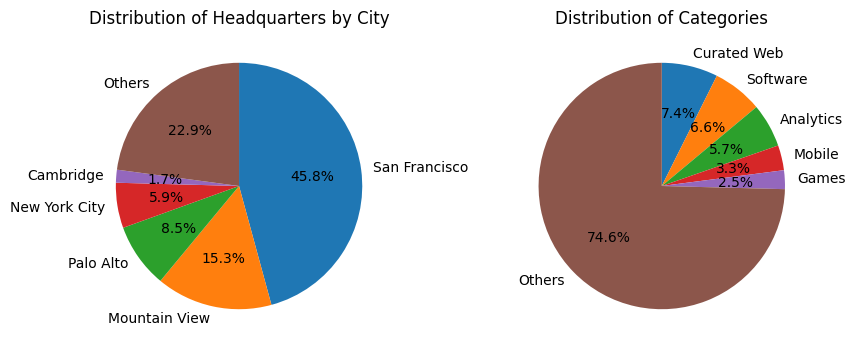

In [12]:
city_counts = filtered_df['Headquarters (City)'].value_counts()
top_5_cities = city_counts.head(5)  # Get the top 5 cities
others_count = city_counts[5:].sum()  # Sum the counts of the remaining cities
city_counts = pd.concat([top_5_cities, pd.Series([others_count], index=['Others'])])

industry_counts = filtered_df['Categories'].value_counts()
top_5_industries = industry_counts.head(5)  # Get the top 5 cities
others_count = industry_counts[5:].sum()  # Sum the counts of the remaining cities
industry_counts = pd.concat([top_5_industries, pd.Series([others_count], index=['Others'])])

# Create a 3x1 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax = axes[0]
ax.pie(city_counts.values, labels=city_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
ax.set_title("Distribution of Headquarters by City")

ax = axes[1]
ax.pie(industry_counts.values, labels=industry_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
ax.set_title("Distribution of Categories")

plt.show()

### Include additional filters if desired (example: specific city)
Se desejável, incluir filtros adicionais (exemplo: uma cidade específica)

In [13]:
filtered_df_nyc = filtered_df[filtered_df['Headquarters (City)'] == 'New York City']
df = filtered_df_nyc[['Company', 'Description', 'Categories', 'Website']]
df.reset_index(drop=True, inplace=True)
df

,Company,Description,Categories,Website
0,MessageParty,MessageParty is a mobile blogging service for ...,"Location Based Services, Blogging Platforms, M...",http://messageparty.com
1,Errplane,Errplane is a service enabling users to monito...,Software,http://errplane.com
2,TradeBlock,Digital currency data and analysis,"Financial Services, Bitcoin",http://tradeblock.com
3,SmartAsset,SmartAsset is a finance platform that empowers...,"Sales and Marketing, Finance",http://www.smartasset.com/welcome
4,MemSQL,MemSQL is a real-time analytics platform helpi...,Analytics,http://www.memsql.com
5,DataNitro,DataNitro integrates Excel with Python. It's t...,"Finance, Software",http://www.datanitro.com
6,Regalii,Mobile remittances,NaN,http://regalii.com


<img align="right" width="100" height="100" src="http://drive.google.com/uc?export=view&id=1ttMUhkBOL7pXlxuqBb5EamSJj_jwRQUo">

# Create Cover Letters for the startups with best fit
Criar Cover Letters para as startups melhor relacionadas

In [18]:
json_list = df.to_dict(orient='records')

for i in range(min(3, len(df))):  # Limiting to 3 cover letters, due to Gemini restrictions (too many requests)
  company_data = json.dumps(json_list[i])
  prompt = f"""
  Consider the following curriculum of a professional:
  {file_content}

  Consider the following information of a company:
  {company_data}

  Draft a cover letter for the professional to this company, with the objective of
  convincing the company to consider the professional for hiring. Highlight the professional's
  skills and experiences that are most relevant to the company. Emphasize how the professional's
  expertise can contribute to the company.
  Do not include header or contact information.
  """
  response = model.generate_content(prompt)
  print(response.text)

## Cover Letter Draft

Dear MessageParty Hiring Team,

I am writing to express my keen interest in joining MessageParty, a company at the forefront of mobile content creation and consumption. With my extensive experience in finance, data analytics, and cross-functional leadership, coupled with my passion for technology and innovation, I am confident I can make a significant contribution to your team.

My career at Procter & Gamble has equipped me with a diverse skillset directly applicable to MessageParty's dynamic environment. In my recent roles, I spearheaded initiatives that drove revenue growth, optimized profitability, and mitigated risk across various business units, including e-commerce – a channel exhibiting remarkable parallels to your mobile platform.  

My ability to analyze complex data sets and translate them into actionable insights would be invaluable to MessageParty.  I developed a Power BI tool that consolidated data from multiple sources, saving time and enabling fast